In [1]:
import numpy as np
import scipy
import math
from numpy.linalg import inv #routine to invert matrix
import matplotlib.pyplot as plt
from qutip import *
import time
import sys
from scipy.interpolate import interp1d
from scipy.special import factorial
from scipy.integrate import ode, complex_ode

In [2]:
def spin_op(N):
    Stot = .5*N

    vz = np.arange(-Stot,Stot+1,1) #spin down is the 0,0 element - convention
    Sz = np.diag(vz, k=0)

    vz1 = np.arange(-Stot+1,Stot+1,1)
    v_ = np.power( Stot*(Stot + 1)*np.ones(N) - np.square(vz1) + vz1 , 0.5 )
    S_ = np.diag(v_, k=+1)

    IIs = np.eye(N+1)*(1.+1j*0.)


    return scipy.sparse.csc_matrix(Sz), scipy.sparse.csc_matrix(S_), scipy.sparse.csc_matrix(IIs)


def photon_op(Nph):

    va = np.arange(1,Nph)
    a = np.diag(np.sqrt(va), k=+1 )
    vN = np.arange(0, Nph)
    N_op = np.diag(vN, k=0)

    IIph = np.eye(Nph)*(1.+1j*0.)

    return scipy.sparse.csc_matrix(a), scipy.sparse.csc_matrix(N_op), scipy.sparse.csc_matrix(IIph)


def Liuvillian(H, list_C, list_decays, dim):
    IId = scipy.sparse.csc_matrix( np.diag(np.ones(dim), k=0) )
    L = ( scipy.sparse.kron(H, IId, format='csc') - scipy.sparse.kron(IId, H.T, format='csc') )*(1+1j*0)

    count = 0
    for c in list_C:
        #decay op.
        L += .5*list_decays[count] * 1j * 2 * scipy.sparse.kron(c , c.conj(), format='csc')
        L += - .5*list_decays[count] * 1j * scipy.sparse.kron( c.conj().T.dot(c) , IId, format='csc' )
        L += - .5*list_decays[count] * 1j * scipy.sparse.kron( IId , c.conj().T.dot(c), format='csc' )
        count += 1

    return L, IId

def system_driven_TC(N, Nph, Omega, g, gamma, kappa):
    dim = (N+1)*Nph

    #Define operators in each Hilbert spaces
    Sz, S_, IIs = spin_op(N)
    a, N_op, IIph = photon_op(Nph)
    #Dicke Ham. in total Hilber space
    H0 = .5*Omega * scipy.sparse.kron( IIph, S_ + S_.conj().T, format='csc' )
    HI = g/np.sqrt(1.*N)*( scipy.sparse.kron(a.conj().T,S_ , format='csc') + scipy.sparse.kron(a, S_.conj().T, format='csc') )    #TavisCummings
    H = H0+HI
    #Jump ops in total Hilber space
    Cph = scipy.sparse.kron(a, IIs, format='csc')
    Cs = scipy.sparse.kron(IIph, S_, format='csc')
    list_C = [Cph, Cs]
    list_decays = [2*gamma, 2*kappa/(1.*N)]
    #Liuvillian
    L, IId = Liuvillian(H, list_C, list_decays, dim)
    trace_v = scipy.sparse.csc_matrix( np.reshape(np.eye(dim), [1, dim*dim] ) ) # Tr[A rho] = matmul( trace_v, matmul( kron(A,IId), rho) )
    # Observables
    PhotonN = scipy.sparse.kron(scipy.sparse.kron(N_op, IIs, format='csc'), IId, format='csc')
    Z = scipy.sparse.kron(scipy.sparse.kron(IIph, Sz, format='csc'), IId, format='csc')/(.5*N)
    list_obs = [PhotonN, Z]

    return L, list_obs, trace_v

In [3]:
def time_evo(rho0, L, trace_v, tau, list_obs):
    #Time evolution
    dt = .05
    iter_t = 101
    #exponential map
    expL = scipy.sparse.linalg.expm(-1j*L*dt)
    #rho = scipy.sparse.csr_matrix( rho0 )
    rho = rho0
    arr_t = []
    arr_evo = []
    for nt in range(iter_t):
        t = dt*nt   
        arr_obs = []
        for obs in list_obs:
            avg_obs =  trace_v.dot(obs.dot(rho) )
            arr_obs.append(avg_obs)
        arr_evo.append(np.asarray(arr_obs[0]) )
        arr_t.append(t)
        rho = expL.dot( rho )
    return np.asarray(arr_t), np.asarray(arr_evo)


def strobo_time_evo(rho0, L, trace_v, tau, list_obs):
    #Time evolution
    iter_t = 100
    tf = 10.
    dt = tf/(1.*iter_t)
    #exponential map
    rho_ = scipy.sparse.linalg.expm_multiply(-1j*L*dt, rho0, 0., iter_t, iter_t)
    arr_t = []
    arr_evo = []
    for nt in range(iter_t-1):
        t = dt*nt
        arr_obs = []
        for obs in list_obs:
            avg_obs =  trace_v.dot(obs.dot(rho_[nt]) )
            arr_obs.append(avg_obs[0])
        arr_evo.append(np.asarray(arr_obs) )
        arr_t.append(t)
    return np.asarray(arr_t), np.asarray(arr_evo)


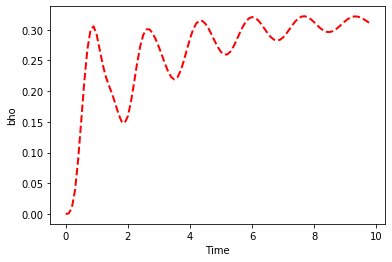

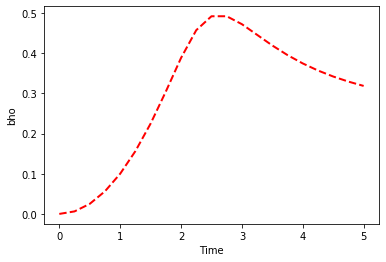

In [8]:
N = 10
Nph = 1+4
dim = (N+1)*Nph

#===============================================================================
Omega = 4. + 1j*0.
g = 1. + 1j*0.
gamma = 2.
kappa = 1.
L, list_obs, trace_v = system_driven_TC(N, Nph, Omega, g, gamma, kappa)
#Initial conditions
psic = np.zeros(Nph, dtype=np.complex_)
psic[0] = 1 #psic[n]=1 => n-photons
psis = np.zeros(N+1, dtype=np.complex_)
psis[0] = 1 #psis[n] = 1 => (-N/2 + n)spin
psi_tot = np.kron(psic, psis)
rho0 = np.kron( psi_tot, psi_tot.conj() )
#Time scale
#tau = 2*np.pi/(np.abs(g))
tau = 1./(np.abs(g))

#Time evolution
#arr_t, arr_evo = time_evo(rho0, L, trace_v, tau, list_obs)
arr_t, arr_evo = strobo_time_evo(rho0, L, trace_v, tau, list_obs)
#===============================================================================
#print(arr_t)
#print(arr_evo)



# plot the spectra
fig, ax = plt.subplots(1, 1)
ax.plot(arr_t, arr_evo[:,0], 'r--', lw=2)
ax.set_xlabel('Time')
ax.set_ylabel('bho')
#plt.axis( [0, 40, 0, 1.1] )
plt.show()

iter_g = 21
dg = .25
g0 = 0.
arr_g = []
arr_evo = []
for ig in range(iter_g):
    Omega = (g0 + dg*ig)*(1.+1j*0.)

    #Omega = 5. + 1j*0.
    g = 1. + 1j*0.
    gamma = 2.
    kappa = 2.
    L, list_obs, trace_v = system_driven_TC(N, Nph, Omega, g, gamma, kappa)

    evals, evecs = scipy.sparse.linalg.eigs(L, k=1, which='LI')
    norm = trace_v.dot( evecs[:,0] )    
    arr_obs = []
    for obs in list_obs:
        avg_obs = trace_v.dot(obs.dot( evecs[:,0] ) )/norm
        arr_obs.append(avg_obs[0])
    arr_evo.append(np.asarray(arr_obs))
    arr_g.append( Omega )

arr_evo = np.asarray(arr_evo)
arr_g = np.asarray(arr_g)
# plot the spectra
fig, ax = plt.subplots(1, 1)
ax.plot(arr_g.real, arr_evo[:,0].real, 'r--', lw=2)
ax.set_xlabel('Time')
ax.set_ylabel('bho')
#plt.axis( [0, 40, 0, 1.1] )
plt.show()

